In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from pmdarima.arima import auto_arima
import multiprocessing as mp
import saxpy
from saxpy.sax import sax_via_window
from saxpy.alphabet import cuts_for_asize
from saxpy.znorm import znorm
from saxpy.paa import paa
from saxpy.sax import ts_to_string
from sklearn.model_selection import train_test_split


df1 = pd.read_csv("data/BATADAL_dataset03.csv")
df2 = pd.read_csv("data/BATADAL_dataset04.csv")
df2.columns = df2.columns.str.replace(" ", "")
dftest = pd.read_csv("data/BATADAL_test_dataset.csv")

In [4]:
## Add the right attack flags
new_attack_df2 = df2[['DATETIME', 'ATT_FLAG']].copy().set_index("DATETIME")
new_attack_df2['ATT_FLAG'] = 0

attack_points = [
    ["13/09/16 23", "16/09/16 00"],
    ["26/09/16 11", "27/09/16 10"],
    ["09/10/16 09", "11/10/16 20"],
    ["29/10/16 19", "02/11/16 16"],
    ["26/11/16 17", "29/11/16 04"],
    ["06/12/16 07", "10/12/16 04"],
    ["14/12/16 15", "19/12/16 04"]
]

for attack_point in attack_points:
    new_attack_df2.loc[attack_point[0]:attack_point[1], 'ATT_FLAG'] = 1
    
new_attack_df2.reset_index(inplace=True)

new_attack_df_test = dftest[['DATETIME']].copy().set_index("DATETIME")
new_attack_df_test['ATT_FLAG'] = 0

attack_points = [
    ["16/01/17 09", "19/01/17 06"],
    ["30/01/17 08", "02/02/17 00"],
    ["09/02/17 03", "10/02/17 09"],
    ["12/02/17 01", "13/02/17 07"],
    ["24/02/17 05", "28/02/17 08"],
    ["10/03/17 14", "13/03/17 21"],
    ["25/03/17 20", "27/03/17 01"]
]

for attack_point in attack_points:
    new_attack_df_test.loc[attack_point[0]:attack_point[1], 'ATT_FLAG'] = 1
    
new_attack_df_test.reset_index(inplace=True)

df2['ATT_FLAG'] = new_attack_df2['ATT_FLAG']
dftest['ATT_FLAG'] = new_attack_df_test['ATT_FLAG']

In [2]:
data = df2.drop("DATETIME",1)

dfy = df2["ATT_FLAG"]
dfy = dfy.replace(-999,0)
x = []
x = pd.DataFrame(x)
for index in range(0,len(data.columns)):
    indexname = "{}".format(data.columns[index])
    dat = data[indexname].values
    amount_of_levels = 3
    window_size = 2

    discrete_signal = []
    for t in range(len(dat)-window_size):
        dat_znorm = znorm(dat[t:t+window_size])
        discrete_signal.append(ts_to_string(dat_znorm, cuts_for_asize(amount_of_levels)))

    x[indexname] = discrete_signal
saxxeddata = x   

In [3]:
saxxeddata = saxxeddata.drop("ATT_FLAG",1)

In [4]:
# saxxeddata["output"] = dfy


In [5]:
targets_for_onehot = saxxeddata.columns
new_df = pd.DataFrame([])

for target in targets_for_onehot:
    temp = pd.get_dummies(saxxeddata[target])
    new_df = pd.concat([new_df, temp],axis=1)



In [31]:
import torch
import torch.nn as nn

In [7]:
# dfy = df2["ATT_FLAG"]
# dfy = dfy.replace(-999,0)
from sklearn.model_selection import train_test_split
data= df2
datay = dfy
data = data.drop("DATETIME",axis=1)
data = data.drop("ATT_FLAG",axis=1)
xTrain, xTest, yTrain, yTest = train_test_split(data, dfy, test_size = 0.2)
xTrain = torch.tensor(xTrain.values,dtype=torch.float)
yTrain = torch.tensor(yTrain.values,dtype=torch.float)
xTest = torch.tensor(xTest.values,dtype=torch.float)
yTest = torch.tensor(yTest.values,dtype=torch.float)


In [8]:

var = df2.drop(["DATETIME","ATT_FLAG"],axis=1).shape[1]
n_in, n_h, n_out, batch_size = var, 10, 1, 5

model = nn.Sequential(nn.Linear(n_in, n_h),
                     nn.ReLU(),
                     nn.Linear(n_h, n_out),
                     nn.Sigmoid())
criterion = torch.nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
for epoch in range(50):
    # Forward Propagation
    y_pred = model(xTrain)
    y_pred_test = model(xTest)
    # Compute and print loss
    loss = criterion(y_pred, yTrain)
    testloss = criterion(y_pred_test,yTest)
    print('Round: ', epoch,' train loss: ', loss.item())
    print("test loss: ", testloss.item())
    # Zero the gradients
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()

Round:  0  train loss:  0.9440285563468933
test loss:  0.9617223143577576
Round:  1  train loss:  0.9440260529518127
test loss:  0.9617197513580322
Round:  2  train loss:  0.9439995884895325
test loss:  0.9616899490356445
Round:  3  train loss:  0.9437834620475769
test loss:  0.9614313840866089
Round:  4  train loss:  0.9423401951789856
test loss:  0.9597901701927185
Round:  5  train loss:  0.9352802634239197
test loss:  0.9528482556343079
Round:  6  train loss:  0.9109997153282166
test loss:  0.9290820360183716
Round:  7  train loss:  0.8478570580482483
test loss:  0.8570886254310608
Round:  8  train loss:  0.687922477722168
test loss:  0.6812738180160522
Round:  9  train loss:  0.41766107082366943
test loss:  0.4017239212989807
Round:  10  train loss:  0.16146795451641083
test loss:  0.14689281582832336
Round:  11  train loss:  0.07924968004226685
test loss:  0.06164178624749184
Round:  12  train loss:  0.05662158876657486
test loss:  0.03906097263097763
Round:  13  train loss:  0.05

In [9]:
which = y_pred[y_pred>0.05]

In [24]:
from pandas import Series
from pandas import DataFrame
from pandas import concat

target_columns = list(df2.columns.drop(["DATETIME","ATT_FLAG"]))

train_df = df2.copy()
sliding_dfs = []

for column in target_columns:
    target_df = train_df[[column]]
    sliding_width = 10
    sliding_df = pd.concat([target_df.shift(t_delta) for t_delta in range(sliding_width)], axis=1)
    sliding_df.columns = ['L_T1_' + str(t_delta) for t_delta in range(sliding_width)]
    sliding_dfs.append(sliding_df)


In [28]:
train_features = pd.concat(sliding_dfs, axis=1)
train_labels = train_df['ATT_FLAG']

In [56]:

var = train_features.shape[1]
n_in, n_h, n_out = var, 10, 1

model = nn.Sequential(nn.Linear(n_in, n_h),
                     nn.ReLU(),
                     nn.Linear(n_h, n_out),
                     nn.Sigmoid())
criterion = torch.nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
for epoch in range(100):
    
    xTrain, xTest, yTrain, yTest = train_test_split(train_features, train_labels, test_size = 0.2)
    xTrain = torch.tensor(xTrain.values,dtype=torch.float)
    yTrain = torch.tensor(yTrain.values,dtype=torch.float)
    xTest = torch.tensor(xTest.values,dtype=torch.float)
    yTest = torch.tensor(yTest.values,dtype=torch.float)
    # Forward Propagation
    
    y_pred = model(xTrain)
    y_pred_test = model(xTest)
    # Compute and print loss
    loss = criterion(y_pred, yTrain)
    testloss = criterion(y_pred_test,yTest)
    print('Round: ', epoch,' train loss: ', loss.item())
    print("test loss: ", testloss.item())
    # perform a backward pass (backpropagation)
    loss.backward()
    
   

Round:  0  train loss:  0.153767928481102
test loss:  0.15595974028110504
Round:  1  train loss:  0.1554887890815735
test loss:  0.14906644821166992
Round:  2  train loss:  0.15279874205589294
test loss:  0.15978364646434784
Round:  3  train loss:  0.15522794425487518
test loss:  0.15024523437023163
Round:  4  train loss:  0.15515971183776855
test loss:  0.15039202570915222
Round:  5  train loss:  0.15313602983951569
test loss:  0.15866871178150177
Round:  6  train loss:  0.15487299859523773
test loss:  0.15163946151733398
Round:  7  train loss:  0.154394268989563
test loss:  0.1538282036781311
Round:  8  train loss:  0.1550922691822052
test loss:  0.150662362575531
Round:  9  train loss:  0.15446734428405762
test loss:  0.1531485915184021
Round:  10  train loss:  0.15634137392044067
test loss:  0.14566658437252045
Round:  11  train loss:  0.15656863152980804
test loss:  0.14481352269649506
Round:  12  train loss:  0.15485621988773346
test loss:  0.15159446001052856
Round:  13  train l

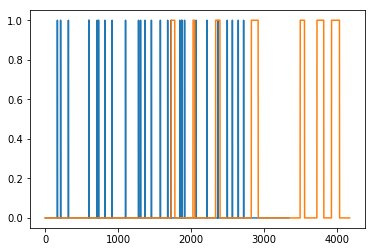

In [72]:
fig, ax = plt.subplots()
threshold = 0.95
sns.lineplot(data=pd.Series([x[0] for x in (y_pred>threshold).tolist()]), ax=ax)
sns.lineplot(data=train_labels, ax=ax)

[1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
